In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import plotly.express as px
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# set plotly parameters
import plotly.io as pio
pio.renderers.default='notebook'

In [343]:
df = pd.read_csv("../../../Data/csv/1TF_BQ_Accidents.csv", header=None)
df = df.rename({19: 'date'}, axis=1)
df['date'] = pd.to_datetime(df['date'])

df = df.groupby('date').size().reset_index(name='count')

C:\Users\hanne\AppData\Local\Temp\ipykernel_13136\3011639115.py:1: DtypeWarning:

Columns (3,7,11) have mixed types. Specify dtype option on import or set low_memory=False.



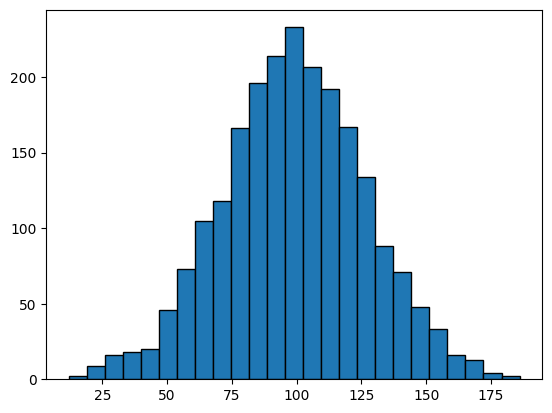

In [344]:
plt.hist(df['count'],edgecolor='black',bins=25)
plt.show()
#This shows a bell curve -> its normally distributed

In [345]:
df['dow'] = df['date'].apply(lambda x: x.weekday())
df['is_weekend'] = df['dow'].isin([5,6])

In [346]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['date_int'] = df['date']

In [347]:
df = df[~((df['month'].isin([3,4,5])) & (df['year']==2020))]
#df.drop(columns=(['year']), inplace=True)

In [348]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [349]:
print(df[['dow', 'day', 'month']].max())

dow       6
day      31
month    12
dtype: int64


In [350]:
df = encode(df,'dow', 6)
df = encode(df,'month', 12)
df = encode(df,'day', 31)

#input_data = df['count']

sc = StandardScaler()
mms = MinMaxScaler()
df['count'] = sc.fit_transform(df['count'].values.reshape(-1,1))

#df['count'] = mms.fit_transform(df['count'].values.reshape(-1,1))

In [351]:
data_train, data_test = train_test_split(df, test_size=0.4,shuffle=False)
data_test, data_val = train_test_split(data_test, test_size=0.5, shuffle = False)

In [376]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation,Dropout
from keras.optimizers import Adam

def train_model(X_train, y_train, X_test, y_test, epochs):
    model = Sequential(
        [
            Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(1, activation="linear")
        ]
    )
    model.compile(optimizer=Adam(), loss="mean_squared_error")
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

    return model, history

In [384]:
def get_encoded_features(df):
    return df[[ 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]

In [385]:
X_train = get_encoded_features(data_train)
X_test = get_encoded_features(data_test)
y_train = data_train['count']
y_test = data_test['count']

In [386]:
model_encoded, encoded_hist = train_model(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=150
)

Epoch 1/150


c:\Users\hanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 845.3099 - val_loss: 10.4505
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5549 - val_loss: 2.3999
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9386 - val_loss: 1.2548
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8787 - val_loss: 1.2496
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8729 - val_loss: 1.1322
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8404 - val_loss: 1.1165
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8494 - val_loss: 1.7473
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1412 - val_loss: 1.2316
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8921 - val_loss: 1.2362
Epoch 10/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0420 - val_loss: 1.3015
Epoch 11/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0651 - val_loss: 1.0310
Epoch 12/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0319 - val

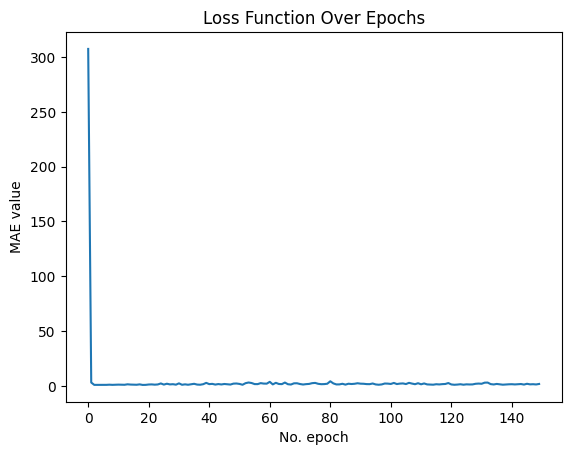

In [387]:
plt.plot(encoded_hist.history['loss'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.show()

In [388]:
X_val_encoded = get_encoded_features(data_val)
y_val = data_val['count']
y_pred = model_encoded.predict(X_val_encoded)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [389]:
from sklearn.metrics import mean_squared_error
mse_encoded = mean_squared_error(y_val, model_encoded.predict(X_val_encoded))
print(mse_encoded)
print(r2_score(y_val, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
1.040503206741763
-0.049078854458243004


In [390]:


#y_pred_inverse = mms.inverse_transform(y_pred)
#y_val_inverse = mms.inverse_transform(y_val.values.reshape(-1,1))

chart = pd.DataFrame()
chart['date'] = data_val['date']
chart['pred'] = y_pred
chart['count'] = y_val

fig = px.line(chart, x='date', y=chart.columns[1:],title='Actual vs. Prediction')
fig.show()